## Carregamento e preparo dos dados

In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
from numba import jit

In [2]:
raw_data = pd.read_csv('yeast.data',
                       sep = '\s+',
                       header=None,
                       names=["Sequence Name","mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "label"]
                      )
raw_data.head()

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,label
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


#### Descartando os atributos categóricos:

In [3]:
df = raw_data.drop(columns=["Sequence Name", "label"])
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


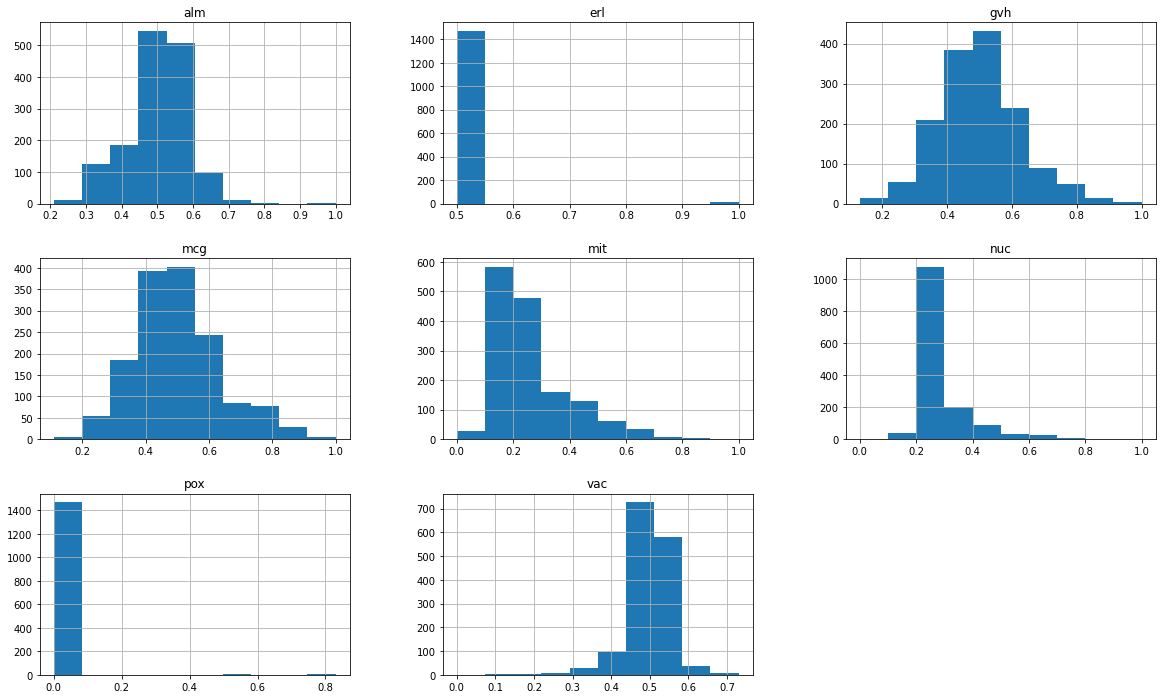

In [4]:
df.hist(figsize=(20,12));

In [5]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


## FCM-DFCV
#### A fuzzy clustering method based on an adaptive quadratic distance for each cluster defined by a diagonal fuzzy covariance matrix

#### Conceito:

É utilizado uma função softmax na inicialização aleatória de U, pois é ideal que a matriz U tenha  $\sum_{i=1}^{c} u_{ik} = 1$, ou seja, a soma dos graus de pertinência de uma amostra para todas as classe tem que ser 1.

In [6]:
3 * np.random.rand(2, 2)

array([[1.81730783, 2.15419804],
       [0.97631265, 2.7035265 ]])

In [7]:
softmax(3 * np.random.rand(2, 2), axis=0)

array([[0.1105379, 0.1274036],
       [0.8894621, 0.8725964]])

#### Classe do modelo:


In [8]:
class FCM_DFCV:
    def __init__(self, n_class, m, T, epsilon):
        self.n_class = n_class
        self.m = m
        self.T = T
        self.epsilon = epsilon
        
    def fit(self, df):
        
        self.n = df.shape[0]
        self.p = df.shape[1]

        for i in range(self.T):
            import pdb;pdb.set_trace()    

            if i == 0:

               #Inicializacao da matriz de perminência aleatória
                U = self.init_U_random()
                
            else:
                #Calculo da matriz de pertinência
                U = self.calc_U(D_M)
                #break
            #Calculo dos prototipos    
            G = self.calc_G(df, U)
            
            #Calculo da matriz diagonal M
            M = self.calc_M(U, df, G)
            
            #Calculo das distâncias quadraticas
            D_M = self.calc_D_M(df, G, M)
            
            #Calculo da função de custo
            J = self.calc_J(U, D_M)
            
            print(J)
            #break
        return U, G, M, D_M, J
    
    
    #Inicialização aleatoria da matrix de pertinencia U    
    def init_U_random(self):
        return softmax(90 * np.random.rand(self.n_class, self.n), axis=0)
    
    def calc_U(self, D_M):
        U = np.zeros([self.n_class, self.n])
        for i in range(self.n_class):
            for k in range(self.n):
                U[i, k] = ( ( (D_M[i, k] / D_M[:,k]+ 0.00001)** (1 / (self.m - 1) ) ).sum() + 0.00001) ** (-1)
                #/ D_M.sum(axis=0) ) ** (1 / (self.m - 1)) ) ** (-1)
        return U
    
    def calc_G(self, df, U):
        G = np.zeros([self.n_class, self.p])
        U_m = U ** self.m
        for i in range(self.n_class):
            
            U_i = U_m[i, :].reshape([self.n, 1])
            #Formula (3)
            G[i, :] = (U_i * df).sum(axis=0) / U_i.sum()
        
        return G
    
    def calc_J(self, U, D_M):
        U_m = U ** self.m
        J = (U_m * D_M).sum()
        return J
    
    def calc_M(self, U, df, G):
        U_m = U ** self.m
        M = np.zeros([self.n_class, self.p, self.p])
        
        for i in range(self.n_class):
            U_i = U_m[i, :].reshape([self.n, 1])
            lambda_i = np.prod((U_i * (df - G[i])**2).sum(axis=0))**(1/self.p) / (U_i*(df - G[i])**2).sum()
            M_i = np.diag(lambda_i)
            M[i, :, :] = M_i
            
        return M
    
    def calc_D_M(self, df, G, M):
        D_M = np.zeros([self.n_class, self.n])
        df_ = df.to_numpy()
        for k in range(self.n):
            for i in range(self.n_class):
                x_k = df_[k].reshape([1,self.p])
                g_i = G[i]
                M_i = M[i]
                # A matriz transposta foi utilizada no ultimo termo
                # pois o x_k já está no formato (1,p) 
                # e será feito o produto matricial com M que é no formato (p, p)
                parcial = np.dot((x_k - g_i), M_i)
                D_M[i, k] =  np.dot(parcial, (x_k - g_i).T)
                
        return D_M

#### Hiperparâmetros

In [9]:
c=10
T=150
epsilon = 1e-10
m = 1.1

In [10]:
model = FCM_DFCV(n_class=c, m=m, T=T, epsilon=epsilon)

In [ ]:
%%time
U, G, M, D_M, J = model.fit(df)

> <ipython-input-8-561b17d58d32>(16)fit()
     14             import pdb;pdb.set_trace()
     15 
---> 16             if i == 0:
     17 
     18                #Inicializacao da matriz de perminência aleatória

ipdb> n
> <ipython-input-8-561b17d58d32>(19)fit()
     17 
     18                #Inicializacao da matriz de perminência aleatória
---> 19                 U = self.init_U_random()
     20 
     21             else:

ipdb> n
> <ipython-input-8-561b17d58d32>(26)fit()
     24                 #break
     25             #Calculo dos prototipos
---> 26             G = self.calc_G(df, U)
     27 
     28             #Calculo da matriz diagonal M

ipdb> U.sum(axis=0)
array([1., 1., 1., ..., 1., 1., 1.])
ipdb> n
> <ipython-input-8-561b17d58d32>(29)fit()
     27 
     28             #Calculo da matriz diagonal M
---> 29             M = self.calc_M(U, df, G)
     30 
     31             #Calculo das distâncias quadraticas

ipdb> n
> <ipython-input-8-561b17d58d32>(32)fit()
     30 
     3

ipdb> n
> <ipython-input-8-561b17d58d32>(32)fit()
     30 
     31             #Calculo das distâncias quadraticas
---> 32             D_M = self.calc_D_M(df, G, M)
     33 
     34             #Calculo da função de custo

ipdb> np.linalg.det(M[1])
0.9999999999999991
ipdb> np.linalg.det(M[0])
1.0000000000000004
ipdb> np.linalg.det(M[10])
*** IndexError: index 10 is out of bounds for axis 0 with size 10
ipdb> np.linalg.det(M[9])
0.9999999999999994
ipdb> np.linalg.det(M[4])
1.0
ipdb> n
> <ipython-input-8-561b17d58d32>(35)fit()
     33 
     34             #Calculo da função de custo
---> 35             J = self.calc_J(U, D_M)
     36 
     37             print(J)

ipdb> n
> <ipython-input-8-561b17d58d32>(37)fit()
     35             J = self.calc_J(U, D_M)
     36 
---> 37             print(J)
     38             #break
     39         return U, G, M, D_M, J

ipdb> n
0.6097848875398326
> <ipython-input-8-561b17d58d32>(13)fit()
     11         self.p = df.shape[1]
     12 
---> 13        

ipdb> n
> <ipython-input-8-561b17d58d32>(14)fit()
     12 
     13         for i in range(self.T):
---> 14             import pdb;pdb.set_trace()
     15 
     16             if i == 0:

ipdb> n
> <ipython-input-8-561b17d58d32>(16)fit()
     14             import pdb;pdb.set_trace()
     15 
---> 16             if i == 0:
     17 
     18                #Inicializacao da matriz de perminência aleatória

ipdb> n
> <ipython-input-8-561b17d58d32>(23)fit()
     21             else:
     22                 #Calculo da matriz de pertinência
---> 23                 U = self.calc_U(D_M)
     24                 #break
     25             #Calculo dos prototipos

ipdb> D_M
array([[7.49516809e-05, 7.47365264e-05, 9.05388578e-05, ...,
        1.19500161e-04, 7.93158013e-05, 8.39074302e-05],
       [3.17917343e+05, 3.17917343e+05, 3.17917343e+05, ...,
        3.17917343e+05, 3.17917343e+05, 3.17917343e+05],
       [3.78526304e-04, 3.25991662e-04, 2.83946463e-04, ...,
        1.43277119e-03, 3.26899

<ipython-input-8-561b17d58d32>:50: RuntimeWarning: overflow encountered in power
  U[i, k] = ( ( (D_M[i, k] / D_M[:,k]+ 0.00001)** (1 / (self.m - 1) ) ).sum() + 0.00001) ** (-1)


> <ipython-input-8-561b17d58d32>(26)fit()
     24                 #break
     25             #Calculo dos prototipos
---> 26             G = self.calc_G(df, U)
     27 
     28             #Calculo da matriz diagonal M

ipdb> D_M
array([[7.49516809e-05, 7.47365264e-05, 9.05388578e-05, ...,
        1.19500161e-04, 7.93158013e-05, 8.39074302e-05],
       [3.17917343e+05, 3.17917343e+05, 3.17917343e+05, ...,
        3.17917343e+05, 3.17917343e+05, 3.17917343e+05],
       [3.78526304e-04, 3.25991662e-04, 2.83946463e-04, ...,
        1.43277119e-03, 3.26899035e-04, 1.89525243e-04],
       ...,
       [2.94036759e-05, 2.88954489e-05, 2.93981397e-05, ...,
        3.78087054e-05, 3.95628642e-05, 2.89738460e-05],
       [6.25912966e-41, 6.73161918e-41, 7.82044949e-41, ...,
        1.48382595e-40, 1.02260165e-40, 7.27893494e-41],
       [2.89994332e-07, 2.86366342e-07, 2.95016378e-07, ...,
        3.35091271e-07, 2.92697949e-07, 2.92055158e-07]])
ipdb> U.sum(axis=0)
array([0.99989001, 0.99989001

ipdb> n
> <ipython-input-8-561b17d58d32>(16)fit()
     14             import pdb;pdb.set_trace()
     15 
---> 16             if i == 0:
     17 
     18                #Inicializacao da matriz de perminência aleatória

ipdb> n
> <ipython-input-8-561b17d58d32>(23)fit()
     21             else:
     22                 #Calculo da matriz de pertinência
---> 23                 U = self.calc_U(D_M)
     24                 #break
     25             #Calculo dos prototipos

ipdb> self.calc_U(D_M)


<ipython-input-8-561b17d58d32>:50: RuntimeWarning: invalid value encountered in true_divide
  U[i, k] = ( ( (D_M[i, k] / D_M[:,k]+ 0.00001)** (1 / (self.m - 1) ) ).sum() + 0.00001) ** (-1)
<ipython-input-8-561b17d58d32>:50: RuntimeWarning: divide by zero encountered in true_divide
  U[i, k] = ( ( (D_M[i, k] / D_M[:,k]+ 0.00001)** (1 / (self.m - 1) ) ).sum() + 0.00001) ** (-1)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
ipdb> D_M
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [4.57013684e-05, 4.26266349e-05, 4.30938850e-05, ...,
        5.68290504e-05, 5.58720358e-05, 4.29016636

ipdb> np.linalg.det(M[0])


/home/johnny/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.0
